<Figure size 432x288 with 0 Axes>

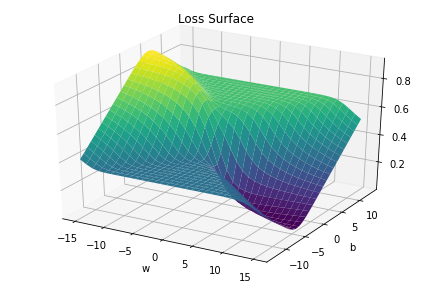

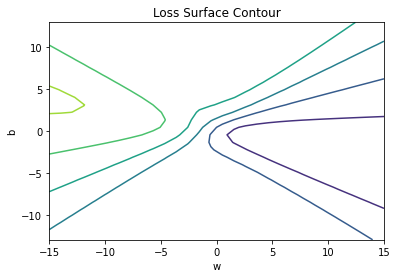

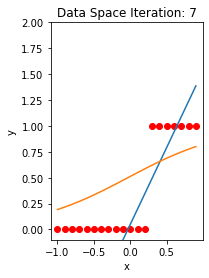

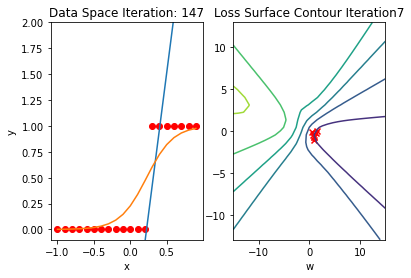

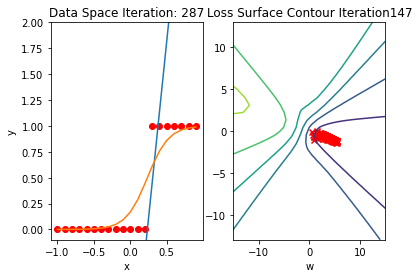

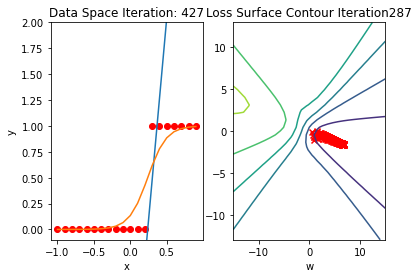

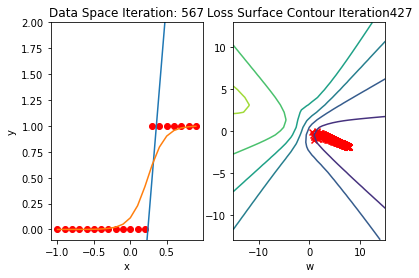

The accuracy:  tensor(1.)


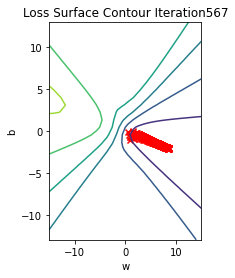

In [14]:
# Import the libraries we need for this lab

import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
torch.manual_seed(0)


# Create class for plotting and the function for plotting


class plot_error_surfaces(object):
    
    # Construstor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30, 30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - (1 / (1 + np.exp(-1*w2 * self.x - b2)))) ** 2)
                count2 += 1   
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize = (7.5, 5))
            plt.axes(projection = '3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1, cmap = 'viridis', edgecolor = 'none')
            plt.title('Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
            
     # Setter
    def set_para_loss(self, model, loss):
        self.n = self.n + 1
        self.W.append(list(model.parameters())[0].item())
        self.B.append(list(model.parameters())[1].item())
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W, self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
        
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label = "training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")
        plt.plot(self.x, 1 / (1 + np.exp(-1 * (self.W[-1] * self.x + self.B[-1]))), label = 'sigmoid')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-0.1, 2))
        plt.title('Data Space Iteration: ' + str(self.n))
        plt.show()
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.title('Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        
# Plot the diagram

def PlotStuff(X, Y, model, epoch, leg = True):
    plt.plot(X.numpy(), model(X).detach().numpy(), label = 'epoch ' + str(epoch))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    if leg == True:
        plt.legend()
    else:
        pass


class Data(Dataset):
  def __init__(self):
    self.x = torch.arange(-1,1,0.1).view(-1,1)
    self.y = torch.zeros(self.x.shape[0],1)
    self.y[self.x[:,0] > 0.2] = 1
    self.len = self.x.shape[0]

  def __getitem__(self,id):
    return self.x[id], self.y[id]

  def __len__(self):
    return self.len

data_set = Data()
get_surface = plot_error_surfaces(15, 13, data_set[:][0], data_set[:][1], 30)
train_loader = DataLoader(dataset=data_set, batch_size= 3)

class LR(nn.Module):
  def __init__(self,in_):
    super(LR,self).__init__()
    self.linear = nn.Linear(in_,1)

  def forward(self,x):
    yhat = torch.sigmoid(self.linear(x))
    return yhat

model = LR(1)

optimiser = optim.SGD(model.parameters(), lr= 2)
criterion = nn.MSELoss()


def train_model(iter):
  for epoch in range(iter):
    for x,y in train_loader:
      yhat = model(x)
      loss = criterion(yhat,y)
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      get_surface.set_para_loss(model, loss.tolist())
    if epoch % 20 == 0:
      get_surface.plot_ps()

train_model(100)
yhat = model(data_set.x)
label = yhat > 0.5
print("The accuracy: ", torch.mean((label == data_set.y.type(torch.ByteTensor)).type(torch.float)))